In [2]:
import os
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import joblib

In [3]:
TRAIN_CSV = "data/processed_train.csv"
TEST_CSV = "data/processed_test.csv"
MODEL_DIR = "models"
RESULTS_DIR = "results"
os.makedirs(MODEL_DIR, exist_ok=True)
os.makedirs(RESULTS_DIR, exist_ok=True)

# Best hyperparameters you found
BEST_UNITS = 64
BEST_DROPOUT = 0.5
BEST_LR = 0.001
EPOCHS = 50
BATCH_SIZE = 32
train_df = pd.read_csv(r"C:\Users\ADMIN\OneDrive\Desktop\predictive_maintenance\data\processed_train.csv")
test_df = pd.read_csv(r"C:\Users\ADMIN\OneDrive\Desktop\predictive_maintenance\data\processed_test.csv")

# Ensure columns exist
if "RUL" not in train_df.columns:
    raise KeyError("RUL column not found in train CSV")


In [4]:
X = train_df.drop(columns=["RUL"]).values
y = train_df["RUL"].values.reshape(-1, 1)

X_test = test_df.drop(columns=["RUL"]).values
y_test = test_df["RUL"].values.reshape(-1, 1)

# --------- Clean NaN / Inf robustly ----------
# convert DataFrame -> numeric if needed (safety), fill NaNs with column mean
# (we use np.nan_to_num after filling to be very safe)
train_df = train_df.apply(pd.to_numeric, errors="coerce")
test_df = test_df.apply(pd.to_numeric, errors="coerce")

train_df = train_df.replace([np.inf, -np.inf], np.nan).fillna(train_df.mean())
test_df  = test_df.replace([np.inf, -np.inf], np.nan).fillna(test_df.mean())


In [5]:
X = train_df.drop(columns=["RUL"]).values
y = train_df["RUL"].values.reshape(-1, 1)
X_test = test_df.drop(columns=["RUL"]).values
y_test = test_df["RUL"].values.reshape(-1, 1)

# Final safety replace
X = np.nan_to_num(X, nan=0.0, posinf=0.0, neginf=0.0)
X_test = np.nan_to_num(X_test, nan=0.0, posinf=0.0, neginf=0.0)
y = np.nan_to_num(y, nan=0.0, posinf=0.0, neginf=0.0)
y_test = np.nan_to_num(y_test, nan=0.0, posinf=0.0, neginf=0.0)

# --------- Scale features and target ----------
scaler_X = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)
X_test_scaled = scaler_X.transform(X_test)

scaler_y = MinMaxScaler()
y_scaled = scaler_y.fit_transform(y)
y_test_scaled = scaler_y.transform(y_test)

# Save scalers
joblib.dump(scaler_X, os.path.join(MODEL_DIR, "scaler_X.pkl"))
joblib.dump(scaler_y, os.path.join(MODEL_DIR, "scaler_y.pkl"))
print("Scalers saved to", MODEL_DIR)

Scalers saved to models


In [6]:
X_scaled = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))
X_test_scaled = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

print("Shapes -> X_train:", X_scaled.shape, "X_test:", X_test_scaled.shape, "y_train:", y_scaled.shape)

# --------- Build model (stacked/optimized simple LSTM)
tf.keras.backend.clear_session()
model = Sequential([
    LSTM(BEST_UNITS, activation="tanh", return_sequences=False, input_shape=(X_scaled.shape[1], X_scaled.shape[2])),
    Dropout(BEST_DROPOUT),
    Dense(1, activation="linear")
])

optimizer = Adam(learning_rate=BEST_LR, clipnorm=1.0)
model.compile(optimizer=optimizer, loss="mse", metrics=["mae"])
model.summary()

Shapes -> X_train: (16561, 1, 38) X_test: (4070, 1, 38) y_train: (16561, 1)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                26368     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 26,433
Trainable params: 26,433
Non-trainable params: 0
_________________________________________________________________


In [7]:
history = model.fit(
    X_scaled, y_scaled,
    validation_data=(X_test_scaled, y_test_scaled),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=8, restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=4)
    ],
    verbose=1
)

# --------- Evaluate & Save
loss, mae = model.evaluate(X_test_scaled, y_test_scaled, verbose=0)
print(f"\nFinal Model Evaluation — Loss: {loss:.4f}, MAE: {mae:.4f}")

# Save model in modern Keras format
model.save(os.path.join(MODEL_DIR, "final_lstm_model.keras"))
# Optional legacy .h5 if you want
model.save(os.path.join(MODEL_DIR, "final_lstm_model.h5"))

# Save metrics
metrics_df = pd.DataFrame([{"loss": float(loss), "mae": float(mae)}])
metrics_df.to_csv(os.path.join(RESULTS_DIR, "final_model_performance.csv"), index=False)
print("Model and metrics saved.")

Epoch 1/50
518/518 [==============================] - 5s 5ms/step - loss: 0.0191 - mae: 0.1044 - val_loss: 0.0075 - val_mae: 0.0650 - lr: 0.0010
Epoch 2/50
518/518 [==============================] - 2s 4ms/step - loss: 0.0143 - mae: 0.0903 - val_loss: 0.0065 - val_mae: 0.0616 - lr: 0.0010
Epoch 3/50
518/518 [==============================] - 2s 4ms/step - loss: 0.0134 - mae: 0.0864 - val_loss: 0.0064 - val_mae: 0.0608 - lr: 0.0010
Epoch 4/50
518/518 [==============================] - 2s 4ms/step - loss: 0.0127 - mae: 0.0838 - val_loss: 0.0062 - val_mae: 0.0596 - lr: 0.0010
Epoch 5/50
518/518 [==============================] - 2s 3ms/step - loss: 0.0125 - mae: 0.0832 - val_loss: 0.0061 - val_mae: 0.0587 - lr: 0.0010
Epoch 6/50
518/518 [==============================] - 2s 4ms/step - loss: 0.0123 - mae: 0.0821 - val_loss: 0.0060 - val_mae: 0.0587 - lr: 0.0010
Epoch 7/50
518/518 [==============================] - 2s 4ms/step - loss: 0.0121 - mae: 0.0815 - val_loss: 0.0061 - val_mae: 0.059

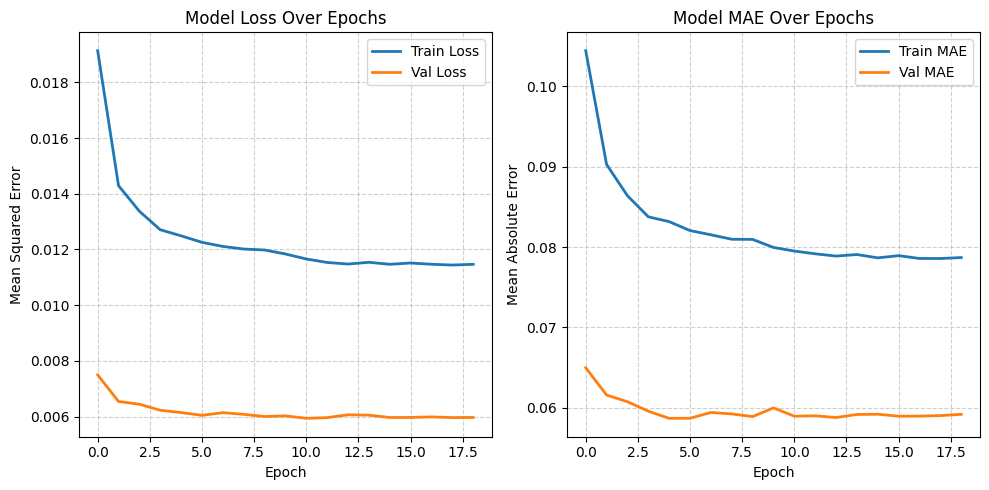

In [9]:
import matplotlib.pyplot as plt


plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss', linewidth=2)
plt.plot(history.history['val_loss'], label='Val Loss', linewidth=2)
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Train MAE', linewidth=2)
plt.plot(history.history['val_mae'], label='Val MAE', linewidth=2)
plt.title('Model MAE Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()


In [10]:
# Re-save model properly in all formats
import tensorflow as tf

# 1) Save as .h5 (most compatible)
model.save("models/final_clean_rul_model.h5", include_optimizer=False)

# 2) Save as new .keras format
model.save("models/final_clean_rul_model.keras")

# 3) Save TensorFlow SavedModel
tf.saved_model.save(model, "models/final_clean_savedmodel")

print("ALL MODEL EXPORTS COMPLETED SUCCESSFULLY")


INFO:tensorflow:Assets written to: models/final_clean_savedmodel\assets


INFO:tensorflow:Assets written to: models/final_clean_savedmodel\assets


ALL MODEL EXPORTS COMPLETED SUCCESSFULLY


In [ ]:
import joblib
scaler = joblib.load(r"C:\Users\ADMIN\OneDrive\Desktop\predictive_maintenance\notebooks\models\scaler_X.pkl")
print("Scaler expects:", scaler.n_features_in_)


Scaler expects: 38


: 